# Overall findings about data:
### Total 27 logos in data
### 809 Training images and 270 testing images out of which only 135 are labeled
### training set has 30 images per class but one image is missing
### test set has 5 images per class

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

%matplotlib inline

In [2]:
data = pd.read_table('flickr_logos_27_dataset_training_set_annotation.txt',sep=' ',names=['filename','logo' ,'subset', 'x1','y1','x2','y2'],index_col=False)
data.head()

,filename,logo,subset,x1,y1,x2,y2
0,144503924.jpg,Adidas,1,38,12,234,142
1,2451569770.jpg,Adidas,1,242,208,413,331
2,390321909.jpg,Adidas,1,13,5,89,60
3,4761260517.jpg,Adidas,1,43,122,358,354
4,4763210295.jpg,Adidas,1,83,63,130,93


### Since subset is not necessary for classification, hence we can drop it.

In [3]:
data = data.drop('subset',axis=1)

In [4]:
data.isnull().sum()

filename    0
logo        0
x1          0
y1          0
x2          0
y2          0
dtype: int64

### Hence, no null values in training set

### There are so many rows in training data with all current attributes same, hence dropping those rows also 

In [5]:
data = data.drop_duplicates(subset=['filename','logo','x1','y1','x2','y2'], keep='first')
data.reset_index(drop=True, inplace=True)

In [6]:
data.shape

(1261, 6)

### images are not converted in grayscale as color matters a lot in detecting logo

In [7]:
size=(224,224) #input-size for many pre-trained imagenet models like VGG16, resnet50, etc.
def process_image(img_file):
    img=cv2.imread(img_file)
    #print(img.shape) 
    img = cv2.cvtColor( img, cv2.COLOR_BGR2RGB )
    img=cv2.resize(img,size) # resizing all into a common size, as there are many different image sizes
    return img #returning reduced image

### There are multiple rows corresponding to an image as one image can have same logo many times (as can be seen below)
### Hence, only picking only one row for one image

In [8]:
train_imgs = []
train_labels = []
for each in data['filename'].value_counts().index:
    train_imgs.append(process_image('flickr_logos_27_dataset_images/'+each))
    train_labels.append( data[data['filename']==each]['logo'].values[0] )
    
    

In [9]:
np.unique(train_labels,return_counts=True) # Pepsi has only 29 values

(array(['Adidas', 'Apple', 'BMW', 'Citroen', 'Cocacola', 'DHL', 'Fedex',
        'Ferrari', 'Ford', 'Google', 'HP', 'Heineken', 'Intel',
        'McDonalds', 'Mini', 'Nbc', 'Nike', 'Pepsi', 'Porsche', 'Puma',
        'RedBull', 'Sprite', 'Starbucks', 'Texaco', 'Unicef', 'Vodafone',
        'Yahoo'], dtype='<U9'),
 array([30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30,
        29, 30, 30, 30, 30, 30, 30, 30, 30, 30]))

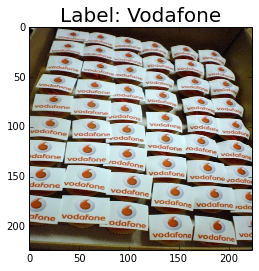

In [10]:
plt.imshow(train_imgs[0])
plt.title('Label: '+train_labels[0],fontsize=20)
plt.show()

## one-hot encoding of target variable and normalisation of data
#### since its label encoding can be harmful as it will result in numeric values which further indicate something like sprite > apple , which should not be done.

In [11]:
train_imgs = np.array(train_imgs)
train_labels = np.array(train_labels)

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
train_labels  = le.fit_transform(train_labels) # as keras one hot endoing works only for integers

from keras.utils import np_utils
train_labels = np_utils.to_categorical(train_labels,27)


from keras.applications.resnet50 import preprocess_input, decode_predictions
train_imgs = preprocess_input(train_imgs)
'''train_imgs= train_imgs.astype('float32') #normalisation
train_imgs = train_imgs - train_imgs.mean()
train_imgs = train_imgs / 255
train_imgs = train_imgs.reshape(train_imgs.shape[0],3,size[0], size[1]) # channels first format'''

## traint_validation_split

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(train_imgs, train_labels , stratify = train_labels)



## As we have less data as needed to train a deep neural network, so we perform data augmentation

In [25]:
from keras.preprocessing.image import ImageDataGenerator

# data generator
def create_datagen():
    datagen = ImageDataGenerator(
    featurewise_center=True, # Set input mean to 0 over the dataset, feature-wise
    featurewise_std_normalization=True, # Divide inputs by std of the dataset, feature-wise
    zca_whitening=True, # Apply ZCA whitening
    rotation_range=30, # Degree range for random rotations
    width_shift_range=0.3, # Range for random horizontal shifts
    height_shift_range=0.3, # Range for random vertical shifts
    shear_range=0.2, # hear Intensity (Shear angle in counter-clockwise direction as radians)
    zoom_range=0.3, # Range for random zoom. If a float
    channel_shift_range=0.2, # Range for random channel shifts
    fill_mode='nearest', # Points outside the boundaries of the input are filled according to the given mode
    horizontal_flip=True, # Randomly flip inputs horizontally
    vertical_flip=True, # Randomly flip inputs vertically
  )
    return datagen
# instantiate a data generator
datagen = create_datagen()



### Using pre-trained imagenet models (with body weights only, not head weights) by transfer learning. This is done to reduce computations and to use a model which has been trained on a very large dataset

In [26]:
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.applications.resnet50 import ResNet50
from keras.layers import GlobalAveragePooling2D, Dense, Dropout
from keras import optimizers

dropout_rate = 0.5

In [ ]:
base_model = ResNet50(weights='imagenet', include_top=False)

x = base_model.output
x = GlobalAveragePooling2D()(x)

x = Dense(1024, activation='relu')(x) 
x = Dropout(dropout_rate)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(dropout_rate)(x)

# a softmax layer for 27 classes
predictions = Dense(27, activation='softmax')(x)

model = Model(input=base_model.input, output=predictions)

# freezing layers except top ones
for layer in base_model.layers:
    layer.trainable = False
adam = optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(optimizer= adam, loss='categorical_crossentropy')


# train only the top layers for, say, 20 epochs
model.fit_generator( datagen.flow(X_train, y_train), samples_per_epoch=len(X_train) * 5, epochs=50, verbose=2, 
                    validation_data = (X_valid,y_valid))


In [ ]:
# make all layers trainable
for layer in model.layers:
    layer.trainable=True

adam = optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(optimizer= adam, loss='categorical_crossentropy')

# train the whole net
model.fit_generator( datagen.flow(X_train, y_train), samples_per_epoch=len(X_train) * 5, epochs=100, verbose=2, 
                    validation_data = (X_valid,y_valid))


## Test data preparation

In [ ]:
test_data = pd.read_table('flickr_logos_27_dataset_query_set_annotation.txt',sep='\t',names=['filename','logo'], na_values='none',index_col=False)
test_data.head()

In [ ]:
test_data.dropna(inplace=True)
test_data.reset_index(drop=True, inplace=True)

test_imgs = []
test_labels = []
for each in test_data['filename'].value_counts().index:
    test_imgs.append(process_image('flickr_logos_27_dataset_images/'+each))
    test_labels.append( test_data[test_data['filename']==each]['logo'].values[0] )
    

In [ ]:
plt.imshow(test_imgs[0])
plt.title('Label: '+test_labels[0],fontsize=20)
plt.show()

In [ ]:
test_imgs = np.array(test_imgs)
test_labels = np.array(test_labels)

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
test_labels  = le.fit_transform(test_labels)

from keras.utils import np_utils
test_labels = np_utils.to_categorical(test_labels,27)

from keras.applications.resnet50 import preprocess_input, decode_predictions
test_imgs = preprocess_input(test_imgs)


In [ ]:
X_test, y_test = test_imgs, test_labels

## Predicted labels

In [ ]:
y_pred = model.predict(X_test)
final_labels = decode_predictions(y_pred, top=3) #returns top 3 predictions for each image

In [ ]:
# Cross-entropy loss score
score = log_loss(y_test, y_pred)